# Resnet Training
This notebook trains a resnet18 model on the plant dataset

In [1]:
import time
import os

import numpy as np
import pandas as pd
from plotnine import *
import sklearn.model_selection
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
import tqdm

In [2]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed)                                                                    
if torch.backends.cudnn.enabled:                                                                
    torch.backends.cudnn.deterministic = True                                                   
    torch.backends.cudnn.benchmark = False

In [3]:
data_dir = '../data/'

data_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

image_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = data_transform)

train_indices, tune_indices = sklearn.model_selection.train_test_split(np.arange(len(image_dataset)), 
                                                                       test_size=.1, random_state=seed)

train_data = torch.utils.data.Subset(image_dataset, train_indices)
tune_data = torch.utils.data.Subset(image_dataset, tune_indices)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
tune_dataloader = torch.utils.data.DataLoader(tune_data)

dataset_size = len(image_dataset)
class_names = image_dataset.classes

device = torch.device("cuda")

model = torchvision.models.resnet18(num_classes = 12)
#model = torchvision.models.vgg19(num_classes = 12)

criterion = nn.CrossEntropyLoss()
criterion = criterion.cpu()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.to(device)
overall_step = 0
epochs = 250

best_tune_loss = None
tune_losses = []
train_losses = []
tune_accuracies = []

for epoch in tqdm.tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    train_loss = 0
    tune_loss = 0
    tune_correct = 0
    for data in tqdm.tqdm_notebook(train_dataloader, total=len(train_dataloader)):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    
    for data in tune_dataloader:
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)
            
            tune_loss += criterion(outputs, labels).item()
            tune_correct += accuracy_score(predicted.cpu(), labels.cpu(), normalize=False)
    
    tune_losses.append(tune_loss)
    train_losses.append(train_loss)

    accuracy = tune_correct / len(tune_data)
    tune_accuracies.append(accuracy)
    
    print('Epoch:\t{}\tTrain Loss:\t{}\tTune Loss:\t{}\tTune Acc:\t{}'.format(epoch, train_loss, 
                                                                              tune_loss, accuracy))
            
    # Save model
    if best_tune_loss is None or tune_loss < best_tune_loss:
        best_tune_loss = tune_loss
        torch.save(model.state_dict(), '../results/trained_resnet.pkl')


Epoch:	0	Train Loss:	548.6915876865387	Tune Loss:	1468.5139306783676	Tune Acc:	0.12421052631578948



Epoch:	1	Train Loss:	402.03591734170914	Tune Loss:	1301.3681598901749	Tune Acc:	0.14105263157894737



Epoch:	2	Train Loss:	315.882990449667	Tune Loss:	1551.8972994089127	Tune Acc:	0.11578947368421053



Epoch:	3	Train Loss:	247.24707740545273	Tune Loss:	1384.6978368759155	Tune Acc:	0.23789473684210527



Epoch:	4	Train Loss:	207.6626035273075	Tune Loss:	1279.8943843245506	Tune Acc:	0.18736842105263157



Epoch:	5	Train Loss:	167.5299902409315	Tune Loss:	1235.6117017269135	Tune Acc:	0.13894736842105262



Epoch:	6	Train Loss:	134.6056137830019	Tune Loss:	1045.2086673378944	Tune Acc:	0.19789473684210526



Epoch:	7	Train Loss:	110.07910755649209	Tune Loss:	1134.5502260029316	Tune Acc:	0.2694736842105263



Epoch:	8	Train Loss:	95.19414136558771	Tune Loss:	950.3972937166691	Tune Acc:	0.35368421052631577



Epoch:	9	Train Loss:	82.28978898376226	Tune Loss:	1180.862587571144	Tune Acc:	0.2336842105263158



Epoch:	10	Train Loss:	71.76364037394524	Tune Loss:	969.7298200726509	Tune Acc:	0.35157894736842105



Epoch:	11	Train Loss:	66.13333196938038	Tune Loss:	1043.1012538075447	Tune Acc:	0.3368421052631579



Epoch:	12	Train Loss:	52.83940030634403	Tune Loss:	1156.7327128052711	Tune Acc:	0.2505263157894737



Epoch:	13	Train Loss:	51.532502859830856	Tune Loss:	1076.2641405016184	Tune Acc:	0.28210526315789475



Epoch:	14	Train Loss:	51.02258363366127	Tune Loss:	909.438968539238	Tune Acc:	0.4168421052631579



Epoch:	15	Train Loss:	41.72722136974335	Tune Loss:	900.0400095880032	Tune Acc:	0.4673684210526316



Epoch:	16	Train Loss:	36.92094653472304	Tune Loss:	985.5467363595963	Tune Acc:	0.4063157894736842



Epoch:	17	Train Loss:	39.43524991348386	Tune Loss:	1080.471153460443	Tune Acc:	0.31157894736842107



Epoch:	18	Train Loss:	40.36905665695667	Tune Loss:	1048.118775486946	Tune Acc:	0.45473684210526316



Epoch:	19	Train Loss:	28.70790608972311	Tune Loss:	849.7522884458303	Tune Acc:	0.38105263157894737



Epoch:	20	Train Loss:	20.18341000750661	Tune Loss:	1222.2308084107935	Tune Acc:	0.3157894736842105



Epoch:	21	Train Loss:	31.54709506034851	Tune Loss:	1735.1340750455856	Tune Acc:	0.1431578947368421



Epoch:	22	Train Loss:	22.516830558655784	Tune Loss:	1285.3871641382575	Tune Acc:	0.3389473684210526



Epoch:	23	Train Loss:	19.856387846171856	Tune Loss:	1082.123056679964	Tune Acc:	0.2905263157894737



Epoch:	24	Train Loss:	25.238225863315165	Tune Loss:	1084.120378497988	Tune Acc:	0.37473684210526315



Epoch:	25	Train Loss:	19.59069470036775	Tune Loss:	1127.2412994876504	Tune Acc:	0.3494736842105263



Epoch:	26	Train Loss:	11.243839148432016	Tune Loss:	1144.2883545793593	Tune Acc:	0.3368421052631579



Epoch:	27	Train Loss:	23.22482005227357	Tune Loss:	1019.5284406244755	Tune Acc:	0.3705263157894737



Epoch:	28	Train Loss:	14.206595407798886	Tune Loss:	890.6454185657203	Tune Acc:	0.4378947368421053



Epoch:	29	Train Loss:	9.54672490246594	Tune Loss:	1144.5031714476645	Tune Acc:	0.4463157894736842



Epoch:	30	Train Loss:	16.06021372973919	Tune Loss:	1261.055427826941	Tune Acc:	0.35157894736842105



Epoch:	31	Train Loss:	12.062399310991168	Tune Loss:	1167.8909379430115	Tune Acc:	0.3663157894736842



Epoch:	32	Train Loss:	14.464121593162417	Tune Loss:	1227.7805895823985	Tune Acc:	0.35157894736842105



Epoch:	33	Train Loss:	6.830937126651406	Tune Loss:	916.9426431013271	Tune Acc:	0.4905263157894737



Epoch:	34	Train Loss:	8.369235131889582	Tune Loss:	727.8296914435923	Tune Acc:	0.5810526315789474



Epoch:	35	Train Loss:	18.518699806183577	Tune Loss:	1773.8127785474062	Tune Acc:	0.21894736842105264



Epoch:	36	Train Loss:	9.79000260743004	Tune Loss:	1101.6247301995754	Tune Acc:	0.4189473684210526



Epoch:	37	Train Loss:	13.599318079650402	Tune Loss:	1283.4986885916442	Tune Acc:	0.4105263157894737



Epoch:	38	Train Loss:	16.296446464955807	Tune Loss:	719.5979326963425	Tune Acc:	0.5831578947368421



Epoch:	39	Train Loss:	19.36380159854889	Tune Loss:	816.9523744955659	Tune Acc:	0.5978947368421053



Epoch:	40	Train Loss:	4.991740739613306	Tune Loss:	1029.099280423019	Tune Acc:	0.44



Epoch:	41	Train Loss:	12.308501219376922	Tune Loss:	1340.4137624241412	Tune Acc:	0.3705263157894737



Epoch:	42	Train Loss:	17.157297375262715	Tune Loss:	1158.1035996973515	Tune Acc:	0.42526315789473684



Epoch:	43	Train Loss:	3.555016493424773	Tune Loss:	787.5498739443719	Tune Acc:	0.5515789473684211



Epoch:	44	Train Loss:	15.932598194107413	Tune Loss:	822.8765350170434	Tune Acc:	0.5536842105263158



Epoch:	45	Train Loss:	9.320507552183699	Tune Loss:	1168.94973941613	Tune Acc:	0.37473684210526315



Epoch:	46	Train Loss:	13.471099404618144	Tune Loss:	1003.0722725633532	Tune Acc:	0.4863157894736842



Epoch:	47	Train Loss:	18.24504987837281	Tune Loss:	839.864948188886	Tune Acc:	0.5515789473684211



Epoch:	48	Train Loss:	3.035442864987999	Tune Loss:	901.8223273092881	Tune Acc:	0.5515789473684211



Epoch:	49	Train Loss:	0.714826684910804	Tune Loss:	832.1954695768654	Tune Acc:	0.5768421052631579



Epoch:	50	Train Loss:	0.39481246657669544	Tune Loss:	841.2487689331174	Tune Acc:	0.6021052631578947



Epoch:	51	Train Loss:	11.005004908889532	Tune Loss:	1103.163657527417	Tune Acc:	0.4694736842105263



Epoch:	52	Train Loss:	7.217154557467438	Tune Loss:	829.1311984285712	Tune Acc:	0.5452631578947369



Epoch:	53	Train Loss:	10.016714049968868	Tune Loss:	1243.7773186843842	Tune Acc:	0.3831578947368421



Epoch:	54	Train Loss:	8.698338409420103	Tune Loss:	1129.3434252999723	Tune Acc:	0.4694736842105263



Epoch:	55	Train Loss:	5.5127986976876855	Tune Loss:	1239.5962012894452	Tune Acc:	0.4673684210526316



Epoch:	56	Train Loss:	1.94954954367131	Tune Loss:	917.3436250574887	Tune Acc:	0.48210526315789476



Epoch:	57	Train Loss:	9.286450064275414	Tune Loss:	913.8046264676377	Tune Acc:	0.5326315789473685



Epoch:	58	Train Loss:	12.60968848085031	Tune Loss:	1270.4292666763067	Tune Acc:	0.4189473684210526



Epoch:	59	Train Loss:	3.949776479974389	Tune Loss:	1000.1906435219571	Tune Acc:	0.5515789473684211



Epoch:	60	Train Loss:	15.5793512519449	Tune Loss:	1208.7997763417661	Tune Acc:	0.4631578947368421



Epoch:	61	Train Loss:	3.766491385176778	Tune Loss:	1026.1424213685095	Tune Acc:	0.5410526315789473



Epoch:	62	Train Loss:	1.0371657954528928	Tune Loss:	1443.2005097828805	Tune Acc:	0.4189473684210526



Epoch:	63	Train Loss:	0.5841645621694624	Tune Loss:	1015.3450692098122	Tune Acc:	0.56



Epoch:	64	Train Loss:	10.53084837924689	Tune Loss:	739.3316312413663	Tune Acc:	0.6



Epoch:	65	Train Loss:	11.885479032993317	Tune Loss:	1115.2058161869645	Tune Acc:	0.49473684210526314



Epoch:	66	Train Loss:	5.915297670289874	Tune Loss:	1043.6014203655068	Tune Acc:	0.5052631578947369



Epoch:	67	Train Loss:	4.476659593172371	Tune Loss:	944.991589743644	Tune Acc:	0.5515789473684211



Epoch:	68	Train Loss:	9.25336207201326	Tune Loss:	860.0008890368044	Tune Acc:	0.6378947368421053



Epoch:	69	Train Loss:	2.1010210240892775	Tune Loss:	880.8657008167356	Tune Acc:	0.5705263157894737



Epoch:	70	Train Loss:	1.5324594555422664	Tune Loss:	842.3973023332655	Tune Acc:	0.6147368421052631



Epoch:	71	Train Loss:	5.228322982788086	Tune Loss:	949.5591503232718	Tune Acc:	0.5684210526315789



Epoch:	72	Train Loss:	14.631287335650995	Tune Loss:	1176.1988893977832	Tune Acc:	0.4863157894736842



Epoch:	73	Train Loss:	5.196398289263016	Tune Loss:	999.0095807297621	Tune Acc:	0.5705263157894737



Epoch:	74	Train Loss:	3.545751896686852	Tune Loss:	1124.5717790536582	Tune Acc:	0.49473684210526314



Epoch:	75	Train Loss:	5.693165352247888	Tune Loss:	818.6267508156598	Tune Acc:	0.6757894736842105



Epoch:	76	Train Loss:	0.8867106147226878	Tune Loss:	921.1018168255687	Tune Acc:	0.6063157894736843



Epoch:	77	Train Loss:	2.6746601702980115	Tune Loss:	1497.9282804075629	Tune Acc:	0.4378947368421053



Epoch:	78	Train Loss:	8.01708372621215	Tune Loss:	1032.0910114720464	Tune Acc:	0.48



Epoch:	79	Train Loss:	1.689085834659636	Tune Loss:	959.4024845839012	Tune Acc:	0.6168421052631579



Epoch:	80	Train Loss:	0.43134480679873377	Tune Loss:	848.8565356675535	Tune Acc:	0.64



Epoch:	81	Train Loss:	0.13040185841964558	Tune Loss:	777.6525055951206	Tune Acc:	0.6821052631578948



Epoch:	82	Train Loss:	0.06438179686665535	Tune Loss:	842.9952935031615	Tune Acc:	0.6589473684210526



Epoch:	83	Train Loss:	8.099347325682174	Tune Loss:	1089.930330705829	Tune Acc:	0.5810526315789474



Epoch:	84	Train Loss:	14.590476705227047	Tune Loss:	1205.3749498538673	Tune Acc:	0.5368421052631579



Epoch:	85	Train Loss:	12.234524031475303	Tune Loss:	836.3615474700928	Tune Acc:	0.6378947368421053



Epoch:	86	Train Loss:	1.466474386092159	Tune Loss:	934.5690868739039	Tune Acc:	0.6126315789473684



Epoch:	87	Train Loss:	0.21235059259925038	Tune Loss:	805.7286055441946	Tune Acc:	0.64



Epoch:	88	Train Loss:	1.6542058661580086	Tune Loss:	816.8396163266152	Tune Acc:	0.6126315789473684



Epoch:	89	Train Loss:	8.093585525639355	Tune Loss:	1010.4336904529482	Tune Acc:	0.6105263157894737



Epoch:	90	Train Loss:	8.466088507557288	Tune Loss:	1076.334670132026	Tune Acc:	0.6021052631578947



Epoch:	91	Train Loss:	6.946593107655644	Tune Loss:	1240.543422728777	Tune Acc:	0.5052631578947369



Epoch:	92	Train Loss:	2.782810175791383	Tune Loss:	943.9340519797988	Tune Acc:	0.5389473684210526



Epoch:	93	Train Loss:	7.132105375800165	Tune Loss:	760.8254122361541	Tune Acc:	0.5936842105263158



Epoch:	94	Train Loss:	0.8268145368565456	Tune Loss:	829.811836803332	Tune Acc:	0.6294736842105263



Epoch:	95	Train Loss:	2.5549602935425355	Tune Loss:	1263.9493866506964	Tune Acc:	0.5242105263157895



Epoch:	96	Train Loss:	3.460976389236748	Tune Loss:	853.1956105837598	Tune Acc:	0.6126315789473684



Epoch:	97	Train Loss:	5.452211340889335	Tune Loss:	997.6468648165464	Tune Acc:	0.5557894736842105



Epoch:	98	Train Loss:	7.792922799781081	Tune Loss:	859.5459823198617	Tune Acc:	0.631578947368421



Epoch:	99	Train Loss:	2.357952795922756	Tune Loss:	771.0793352480978	Tune Acc:	0.6357894736842106



Epoch:	100	Train Loss:	5.485795143365976	Tune Loss:	949.8624716312625	Tune Acc:	0.5810526315789474



Epoch:	101	Train Loss:	2.6532341979145713	Tune Loss:	704.9926090463996	Tune Acc:	0.6610526315789473



Epoch:	102	Train Loss:	0.4438639498548582	Tune Loss:	803.9968673177063	Tune Acc:	0.68



Epoch:	103	Train Loss:	3.4406516416929662	Tune Loss:	757.5199130382389	Tune Acc:	0.6968421052631579



Epoch:	104	Train Loss:	8.61555053293705	Tune Loss:	1047.6800142042339	Tune Acc:	0.5557894736842105



Epoch:	105	Train Loss:	5.731347457272932	Tune Loss:	947.7937927208841	Tune Acc:	0.6063157894736843



Epoch:	106	Train Loss:	1.7413837276399136	Tune Loss:	965.5414240108803	Tune Acc:	0.5978947368421053



Epoch:	107	Train Loss:	5.382871389854699	Tune Loss:	933.6965166046284	Tune Acc:	0.6210526315789474



Epoch:	108	Train Loss:	0.8545922792200145	Tune Loss:	828.3317845859565	Tune Acc:	0.6926315789473684



Epoch:	109	Train Loss:	2.775513969205349	Tune Loss:	1455.4826733563095	Tune Acc:	0.47368421052631576



Epoch:	110	Train Loss:	8.14893214055337	Tune Loss:	903.1568462876603	Tune Acc:	0.5957894736842105



Epoch:	111	Train Loss:	7.625242987181991	Tune Loss:	849.9219634011388	Tune Acc:	0.6126315789473684



Epoch:	112	Train Loss:	6.997284722805489	Tune Loss:	961.3406725972891	Tune Acc:	0.6547368421052632



Epoch:	113	Train Loss:	5.490495434729382	Tune Loss:	720.2275440730155	Tune Acc:	0.6821052631578948



Epoch:	114	Train Loss:	0.5725183655740693	Tune Loss:	705.8670915663242	Tune Acc:	0.6652631578947369



Epoch:	115	Train Loss:	4.216108093038201	Tune Loss:	824.3087182231247	Tune Acc:	0.7094736842105264



Epoch:	116	Train Loss:	3.5098630525171757	Tune Loss:	1041.721548720263	Tune Acc:	0.5810526315789474



Epoch:	117	Train Loss:	3.539193124976009	Tune Loss:	800.8832441887353	Tune Acc:	0.6421052631578947



Epoch:	118	Train Loss:	1.154433535411954	Tune Loss:	724.1924827154726	Tune Acc:	0.6736842105263158



Epoch:	119	Train Loss:	2.2563093453645706	Tune Loss:	999.9053742010146	Tune Acc:	0.6968421052631579



Epoch:	120	Train Loss:	5.451033231569454	Tune Loss:	794.0694789455738	Tune Acc:	0.6757894736842105



Epoch:	121	Train Loss:	4.823252195783425	Tune Loss:	1224.2201326601207	Tune Acc:	0.6042105263157894



Epoch:	122	Train Loss:	0.5323212444782257	Tune Loss:	920.7484710031422	Tune Acc:	0.6631578947368421



Epoch:	123	Train Loss:	0.25172512482095044	Tune Loss:	1064.846704266034	Tune Acc:	0.6294736842105263



Epoch:	124	Train Loss:	4.581895149312913	Tune Loss:	1161.4556148946285	Tune Acc:	0.5642105263157895



Epoch:	125	Train Loss:	6.6404951637014165	Tune Loss:	837.5152412392199	Tune Acc:	0.6673684210526316



Epoch:	126	Train Loss:	5.297042449936271	Tune Loss:	943.5123066678643	Tune Acc:	0.608421052631579



Epoch:	127	Train Loss:	1.685777423903346	Tune Loss:	668.224390059826	Tune Acc:	0.7305263157894737



Epoch:	128	Train Loss:	0.19111545787745854	Tune Loss:	754.5680912612006	Tune Acc:	0.7368421052631579



Epoch:	129	Train Loss:	0.24882035881000775	Tune Loss:	713.3637806323823	Tune Acc:	0.7178947368421053



Epoch:	130	Train Loss:	0.043449146168654806	Tune Loss:	723.2955400496721	Tune Acc:	0.7136842105263158



Epoch:	131	Train Loss:	0.0255021620541811	Tune Loss:	679.9470064565539	Tune Acc:	0.7347368421052631



Epoch:	132	Train Loss:	0.13141543854726478	Tune Loss:	752.4290629494935	Tune Acc:	0.6694736842105263



Epoch:	133	Train Loss:	17.180091910384363	Tune Loss:	1416.8575110770762	Tune Acc:	0.5157894736842106



Epoch:	134	Train Loss:	2.257772459804073	Tune Loss:	1135.8102416861802	Tune Acc:	0.6294736842105263



Epoch:	135	Train Loss:	2.348117757588625	Tune Loss:	1051.320058885729	Tune Acc:	0.6610526315789473



Epoch:	136	Train Loss:	1.2288428619503975	Tune Loss:	954.999639001675	Tune Acc:	0.6694736842105263



Epoch:	137	Train Loss:	8.203905547891452	Tune Loss:	1034.4998186882585	Tune Acc:	0.6673684210526316



Epoch:	138	Train Loss:	1.7311984077095985	Tune Loss:	797.2020747289062	Tune Acc:	0.6505263157894737



Epoch:	139	Train Loss:	0.4256261019036174	Tune Loss:	788.2893682830036	Tune Acc:	0.6631578947368421



Epoch:	140	Train Loss:	0.9366053544508759	Tune Loss:	858.3053620159626	Tune Acc:	0.6505263157894737



Epoch:	141	Train Loss:	2.2603284216796737	Tune Loss:	1510.7712628860027	Tune Acc:	0.4842105263157895



Epoch:	142	Train Loss:	2.606891411279321	Tune Loss:	1793.2253956347704	Tune Acc:	0.5010526315789474



Epoch:	143	Train Loss:	10.10804424629896	Tune Loss:	1017.56649113819	Tune Acc:	0.6105263157894737



Epoch:	144	Train Loss:	7.950441498309374	Tune Loss:	1106.2422826569527	Tune Acc:	0.5831578947368421



Epoch:	145	Train Loss:	3.0026971106417477	Tune Loss:	809.1699065696448	Tune Acc:	0.6568421052631579



Epoch:	146	Train Loss:	1.5029632551595569	Tune Loss:	991.6183129837736	Tune Acc:	0.6147368421052631



Epoch:	147	Train Loss:	0.8703084646258503	Tune Loss:	1248.3223372660577	Tune Acc:	0.5557894736842105



Epoch:	148	Train Loss:	0.9150677903089672	Tune Loss:	932.1141019549104	Tune Acc:	0.6484210526315789



Epoch:	149	Train Loss:	0.6053080358542502	Tune Loss:	938.8419197159819	Tune Acc:	0.6863157894736842



Epoch:	150	Train Loss:	0.18464001889037718	Tune Loss:	1134.9550260212272	Tune Acc:	0.6210526315789474



Epoch:	151	Train Loss:	0.10912325916069676	Tune Loss:	1010.2850170992315	Tune Acc:	0.6357894736842106



Epoch:	152	Train Loss:	0.038283188245259225	Tune Loss:	936.4158357433043	Tune Acc:	0.6989473684210527



Epoch:	153	Train Loss:	0.021891563199460506	Tune Loss:	918.362048602663	Tune Acc:	0.7052631578947368



Epoch:	154	Train Loss:	13.349245657678694	Tune Loss:	1397.2620931174606	Tune Acc:	0.5410526315789473



Epoch:	155	Train Loss:	9.350720828864723	Tune Loss:	1114.2115530073643	Tune Acc:	0.5831578947368421



Epoch:	156	Train Loss:	3.002011214673985	Tune Loss:	885.3610217850655	Tune Acc:	0.64



Epoch:	157	Train Loss:	1.7686583915104563	Tune Loss:	774.6919587822631	Tune Acc:	0.6926315789473684



Epoch:	158	Train Loss:	2.577566159045091	Tune Loss:	949.3527864143252	Tune Acc:	0.6694736842105263



Epoch:	159	Train Loss:	6.992373863700777	Tune Loss:	952.5016945926473	Tune Acc:	0.6673684210526316



Epoch:	160	Train Loss:	1.4984472310170531	Tune Loss:	1031.6994703989476	Tune Acc:	0.6



Epoch:	161	Train Loss:	0.11663075163960457	Tune Loss:	1061.7384247146547	Tune Acc:	0.5873684210526315



Epoch:	162	Train Loss:	0.42608093505259603	Tune Loss:	959.7587419662159	Tune Acc:	0.6273684210526316



Epoch:	163	Train Loss:	0.035507649183273315	Tune Loss:	888.246791830752	Tune Acc:	0.6547368421052632



Epoch:	164	Train Loss:	0.020984663628041744	Tune Loss:	881.7732558348216	Tune Acc:	0.6547368421052632



Epoch:	165	Train Loss:	0.04553773324005306	Tune Loss:	925.6886613760144	Tune Acc:	0.6442105263157895



Epoch:	166	Train Loss:	0.48790173698216677	Tune Loss:	1059.9210941474885	Tune Acc:	0.5978947368421053



Epoch:	167	Train Loss:	11.931184714034316	Tune Loss:	2336.247149758041	Tune Acc:	0.4



Epoch:	168	Train Loss:	5.637230610125698	Tune Loss:	1384.7253404725343	Tune Acc:	0.47578947368421054



Epoch:	169	Train Loss:	2.970051265942555	Tune Loss:	1141.904100105865	Tune Acc:	0.5978947368421053



Epoch:	170	Train Loss:	2.218488408718258	Tune Loss:	1120.2579915393144	Tune Acc:	0.6042105263157894



Epoch:	171	Train Loss:	2.5434635817073286	Tune Loss:	928.6639120406471	Tune Acc:	0.6505263157894737



Epoch:	172	Train Loss:	4.485190894183091	Tune Loss:	880.9514054842293	Tune Acc:	0.6421052631578947



Epoch:	173	Train Loss:	2.0674504407988934	Tune Loss:	817.3534643705934	Tune Acc:	0.7094736842105264



Epoch:	174	Train Loss:	1.2601698419699687	Tune Loss:	1093.5865308120847	Tune Acc:	0.6231578947368421



Epoch:	175	Train Loss:	1.8531724801287055	Tune Loss:	804.5689506456256	Tune Acc:	0.6610526315789473



Epoch:	176	Train Loss:	1.4782093564663228	Tune Loss:	1336.0898426286876	Tune Acc:	0.5242105263157895



Epoch:	177	Train Loss:	4.5524808135814965	Tune Loss:	747.0169323887676	Tune Acc:	0.6863157894736842



Epoch:	178	Train Loss:	7.8238922280143015	Tune Loss:	765.1601105034351	Tune Acc:	0.7157894736842105



Epoch:	179	Train Loss:	1.0228429939597845	Tune Loss:	998.880678659305	Tune Acc:	0.6484210526315789



Epoch:	180	Train Loss:	7.337658395990729	Tune Loss:	1121.6816683150828	Tune Acc:	0.6021052631578947



Epoch:	181	Train Loss:	1.0169819882139564	Tune Loss:	1206.593212660402	Tune Acc:	0.6063157894736843



Epoch:	182	Train Loss:	3.6556260477132128	Tune Loss:	1329.0753801837564	Tune Acc:	0.5747368421052632



Epoch:	183	Train Loss:	0.6538481550912252	Tune Loss:	1155.003810286522	Tune Acc:	0.6105263157894737



Epoch:	184	Train Loss:	1.8962247651070356	Tune Loss:	1070.9484472125769	Tune Acc:	0.6526315789473685



Epoch:	185	Train Loss:	10.031012964900583	Tune Loss:	1177.4625503905118	Tune Acc:	0.5978947368421053



Epoch:	186	Train Loss:	1.7109845263572652	Tune Loss:	904.9072191971354	Tune Acc:	0.6736842105263158



Epoch:	187	Train Loss:	0.22157952406757886	Tune Loss:	837.6581676261267	Tune Acc:	0.6652631578947369



Epoch:	188	Train Loss:	0.25619087973609567	Tune Loss:	954.1899841297418	Tune Acc:	0.6484210526315789



Epoch:	189	Train Loss:	0.8681593618039187	Tune Loss:	1422.3396095894277	Tune Acc:	0.511578947368421



Epoch:	190	Train Loss:	5.342755561694503	Tune Loss:	1005.8062061723322	Tune Acc:	0.6484210526315789



Epoch:	191	Train Loss:	6.443659646436572	Tune Loss:	1145.6585613414645	Tune Acc:	0.64



Epoch:	192	Train Loss:	1.7134013188378958	Tune Loss:	1111.912471132353	Tune Acc:	0.6189473684210526



Epoch:	193	Train Loss:	1.6139083821326494	Tune Loss:	1055.393605407211	Tune Acc:	0.6210526315789474



Epoch:	194	Train Loss:	2.9630415424180683	Tune Loss:	855.7751655466855	Tune Acc:	0.6778947368421052



Epoch:	195	Train Loss:	1.7258650665171444	Tune Loss:	1163.306307695806	Tune Acc:	0.6231578947368421



Epoch:	196	Train Loss:	0.09206598438322544	Tune Loss:	1205.8950250968337	Tune Acc:	0.6357894736842106



Epoch:	197	Train Loss:	0.10574494116008282	Tune Loss:	1002.798027543351	Tune Acc:	0.6336842105263157



Epoch:	198	Train Loss:	0.022730545766535215	Tune Loss:	957.3180462121964	Tune Acc:	0.6505263157894737



Epoch:	199	Train Loss:	0.024264687982736177	Tune Loss:	964.0600635753945	Tune Acc:	0.6526315789473685



Epoch:	200	Train Loss:	0.03509248170303181	Tune Loss:	963.1677099093795	Tune Acc:	0.6652631578947369



Epoch:	201	Train Loss:	0.012078262865543365	Tune Loss:	964.9768230146728	Tune Acc:	0.6652631578947369



Epoch:	202	Train Loss:	0.006278038024902344	Tune Loss:	965.5525179919787	Tune Acc:	0.6652631578947369



Epoch:	203	Train Loss:	0.00935094989836216	Tune Loss:	977.0685060620308	Tune Acc:	0.6568421052631579



Epoch:	204	Train Loss:	0.010431637366593804	Tune Loss:	977.2792588174343	Tune Acc:	0.6736842105263158



Epoch:	205	Train Loss:	0.010526431918378876	Tune Loss:	935.1580304447562	Tune Acc:	0.6652631578947369



Epoch:	206	Train Loss:	0.0045153672497235675	Tune Loss:	916.6742141917348	Tune Acc:	0.6736842105263158



Epoch:	207	Train Loss:	0.027484022080898285	Tune Loss:	1124.973202764988	Tune Acc:	0.64



Epoch:	208	Train Loss:	30.20401908340864	Tune Loss:	1345.4245658777654	Tune Acc:	0.5810526315789474



Epoch:	209	Train Loss:	5.404030622135906	Tune Loss:	704.0536708310246	Tune Acc:	0.6842105263157895



Epoch:	210	Train Loss:	0.5641815541312099	Tune Loss:	818.7118047773838	Tune Acc:	0.6442105263157895



Epoch:	211	Train Loss:	1.26292538898997	Tune Loss:	773.5035048825666	Tune Acc:	0.6842105263157895



Epoch:	212	Train Loss:	0.41153754526749253	Tune Loss:	848.8369765654206	Tune Acc:	0.6842105263157895



Epoch:	213	Train Loss:	0.2408341412277082	Tune Loss:	903.6393078155816	Tune Acc:	0.68



Epoch:	214	Train Loss:	0.06403164681978524	Tune Loss:	808.0505755618215	Tune Acc:	0.6947368421052632



Epoch:	215	Train Loss:	0.18182459224772174	Tune Loss:	801.7997904159129	Tune Acc:	0.6757894736842105



Epoch:	216	Train Loss:	0.19570577144622803	Tune Loss:	918.9044064255431	Tune Acc:	0.6421052631578947



Epoch:	217	Train Loss:	10.318209707096685	Tune Loss:	1504.3551289532334	Tune Acc:	0.5157894736842106



Epoch:	218	Train Loss:	6.199228735174984	Tune Loss:	971.6826623918023	Tune Acc:	0.6842105263157895



Epoch:	219	Train Loss:	0.9054522577207536	Tune Loss:	976.0976654433471	Tune Acc:	0.6905263157894737



Epoch:	220	Train Loss:	0.19526227237656713	Tune Loss:	1043.6999776475132	Tune Acc:	0.7052631578947368



Epoch:	221	Train Loss:	1.8051206830423325	Tune Loss:	881.0335530824959	Tune Acc:	0.7010526315789474



Epoch:	222	Train Loss:	0.6529545018565841	Tune Loss:	767.7167306020856	Tune Acc:	0.6884210526315789



Epoch:	223	Train Loss:	0.3532001720741391	Tune Loss:	838.8825216349214	Tune Acc:	0.7073684210526315



Epoch:	224	Train Loss:	5.339483823394403	Tune Loss:	1072.2684541735798	Tune Acc:	0.6421052631578947



Epoch:	225	Train Loss:	0.10417614551261067	Tune Loss:	798.3730013654567	Tune Acc:	0.7052631578947368



Epoch:	226	Train Loss:	0.1818271941351668	Tune Loss:	975.3255521450192	Tune Acc:	0.6673684210526316



Epoch:	227	Train Loss:	0.050731894249111065	Tune Loss:	911.1772585883737	Tune Acc:	0.6673684210526316



Epoch:	228	Train Loss:	0.012090339791029692	Tune Loss:	912.3557394891977	Tune Acc:	0.68



Epoch:	229	Train Loss:	0.02085293816830358	Tune Loss:	903.4471733029932	Tune Acc:	0.6884210526315789



Epoch:	230	Train Loss:	0.01666264794766903	Tune Loss:	878.2589771067724	Tune Acc:	0.6989473684210527



Epoch:	231	Train Loss:	0.014337619533762336	Tune Loss:	895.7355867475271	Tune Acc:	0.6905263157894737



Epoch:	232	Train Loss:	0.007648904185771244	Tune Loss:	898.6782398372889	Tune Acc:	0.6968421052631579



Epoch:	233	Train Loss:	0.01487564854323864	Tune Loss:	881.3417670009658	Tune Acc:	0.7031578947368421



Epoch:	234	Train Loss:	21.236554600298405	Tune Loss:	1160.2731688227504	Tune Acc:	0.5894736842105263



Epoch:	235	Train Loss:	7.367187347263098	Tune Loss:	1307.7268822193146	Tune Acc:	0.5473684210526316



Epoch:	236	Train Loss:	2.503060910734348	Tune Loss:	1293.3670225460082	Tune Acc:	0.5557894736842105



Epoch:	237	Train Loss:	0.35228921271240665	Tune Loss:	969.7019984843209	Tune Acc:	0.6884210526315789



Epoch:	238	Train Loss:	0.1417757272720337	Tune Loss:	1162.6879299180582	Tune Acc:	0.6231578947368421



Epoch:	239	Train Loss:	2.185011884352889	Tune Loss:	1069.2666688784957	Tune Acc:	0.6526315789473685



Epoch:	240	Train Loss:	2.561508010025136	Tune Loss:	892.6269150841981	Tune Acc:	0.6968421052631579



Epoch:	241	Train Loss:	0.0774739645421505	Tune Loss:	770.009785156697	Tune Acc:	0.7136842105263158



Epoch:	242	Train Loss:	0.0852527841925621	Tune Loss:	904.3278083205223	Tune Acc:	0.6631578947368421



Epoch:	243	Train Loss:	0.03959874909682526	Tune Loss:	921.9250795468688	Tune Acc:	0.6673684210526316



Epoch:	244	Train Loss:	0.15859567001461983	Tune Loss:	884.0829564072192	Tune Acc:	0.671578947368421



Epoch:	245	Train Loss:	0.039925667146235355	Tune Loss:	823.5627422211692	Tune Acc:	0.7010526315789474



Epoch:	246	Train Loss:	0.027600253466516733	Tune Loss:	887.3424689536914	Tune Acc:	0.6821052631578948



Epoch:	247	Train Loss:	0.013506016694009304	Tune Loss:	869.3240212635137	Tune Acc:	0.6884210526315789



Epoch:	248	Train Loss:	3.0657651793826517	Tune Loss:	2864.844201296568	Tune Acc:	0.38105263157894737



Epoch:	249	Train Loss:	21.38746583228931	Tune Loss:	1324.0581532977521	Tune Acc:	0.5852631578947368



In [8]:
metrics = {'epochs': list(range(epochs)), 'tune_losses': tune_losses, 'train_losses': train_losses,
          'tune_accuracies': tune_accuracies}
metric_df = pd.DataFrame.from_dict(metrics)

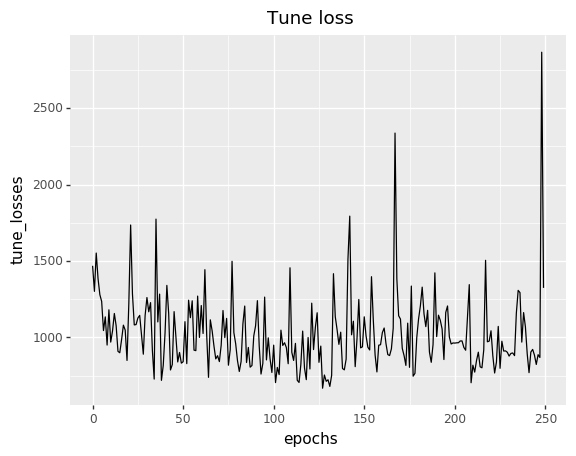

<ggplot: (8791542221665)>

In [9]:
ggplot(metric_df, aes(x = 'epochs', y = 'tune_losses')) + geom_line() + ggtitle('Tune loss')

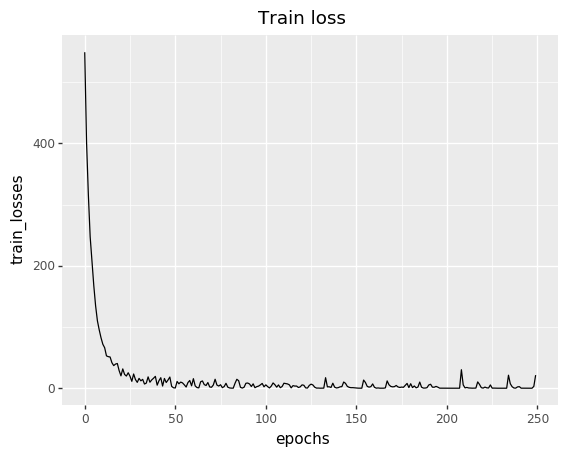

<ggplot: (8791535362757)>

In [10]:
ggplot(metric_df, aes(x = 'epochs', y = 'train_losses')) + geom_line() + ggtitle('Train loss')

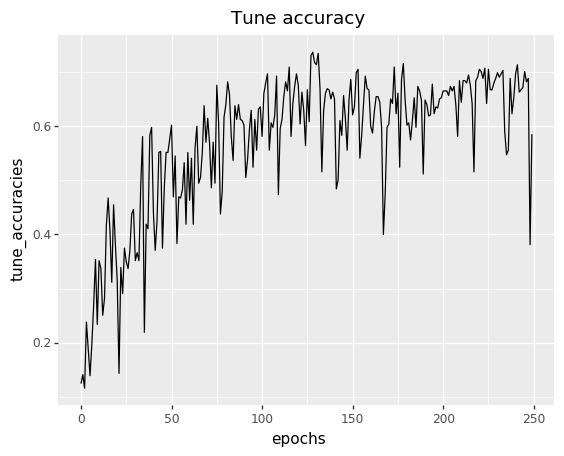

<ggplot: (8791542225441)>

In [11]:
ggplot(metric_df, aes(x = 'epochs', y = 'tune_accuracies')) + geom_line() + ggtitle('Tune accuracy')

In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils import data
import torch
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from skimage.io import imread
from numpy.random import poisson, normal, beta, choice
import time
from copy import deepcopy, copy
from PIL import Image
import bagnets.pytorchnet

from dataset import patchnoiser, uniformnoiser, patchswap, tgenerator

In [2]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed) 

img_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])]
                                   )
dataset = ImageFolder(root=os.path.join(data_dir, "test"), transform=img_transform)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [5]:
model_path = '../results/trained_resnet.pkl'
resnet = models.resnet18(num_classes = 12)
resnet.load_state_dict(torch.load(model_path, map_location=device)
resnet.eval() 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
index = list(range(794))
columns=['file','species']
df_ = pd.DataFrame(index = index, columns=columns)
df_ = df_.fillna(0)

In [7]:
link = os.path.join(data_dir, "test")
testset = tgenerator(link)
testset.viewmode()

Evaluate on clean test set.

Kaggle F1 Score: 0.77581

In [8]:
for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(resnet(im),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_resnet.csv", index = False)

0


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/jlakkis/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


100
200
300
400
500
600
700


Evaluate on uniform noise perturbed test set.

Kaggle F1 Score: 0.16750

In [9]:
testset.setmode_uniformnoise(theta=0.6)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(resnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_unformnoise_resnet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on noisy patch perturbed test set.

Kaggle F1 Score: 0.33375

In [10]:
testset.setmode_noisypatch(theta=0.1,p=30,n=40)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(resnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_noisypatch_resnet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on patchswap perturbed test set.

Kaggle F1 Score: 0.44332

In [11]:
testset.setmode_patchswap(p=20, n=50)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(resnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_patchswap_resnet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on texturized test set.

Kaggle F1 Score: 0.18513

In [12]:
link = os.path.join(data_dir, "texturized")
testset = tgenerator(link)
testset.viewmode()

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(resnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_texturized_resnet.csv", index = False)

0
100
200
300
400
500
600
700
